# Evaluate classification accuracy

This notebook demonstrates how to evaluate classification accuracy of "cross-validated" simulated communities. Due to the unique nature of this analysis, the metrics that we use to evaluate classification accuracy are different from those used for mock.

The key measure here is rate of ``match`` vs. ``overclassification``, hence P/R/F are not useful metrics. Instead, we define and measure the following as percentages:
* Match vs. overclassification rate
    * Match: exact match at level L
    * underclassification: lineage assignment is correct, but shorter than expected (e.g., not to species level)
    * misclassification: incorrect assignment
    
Where ``L`` = taxonomic level being tested


## Functions

In [1]:
from tax_credit.framework_functions import (novel_taxa_classification_evaluation,
                                            extract_per_level_accuracy)
from tax_credit.eval_framework import parameter_comparisons
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis,
                                           rank_optimized_method_performance_by_dataset)

import seaborn.xkcd_rgb as colors
import pandas as pd
from os.path import expandvars, join, exists
from glob import glob
from IPython.display import display, Markdown
%matplotlib inline

## Evaluate classification results
First, enter in filepaths and directory paths where your data are stored, and the destination

In [2]:
project_dir = expandvars("../../")
analysis_name = "cross-validated"
precomputed_results_dir = join(project_dir, "data", "precomputed-results", analysis_name)
expected_results_dir = join(project_dir, "data", analysis_name)
summary_fp = join(precomputed_results_dir, 'evaluate_classification_summary.csv')

results_dirs = glob(join(precomputed_results_dir, '*', '*', '*', '*'))

# we can save plots in this directory
outdir = expandvars("../../../plots/")

This cell performs the classification evaluation and should not be modified.

In [3]:
force = False
if force or not exists(summary_fp):
    accuracy_results = novel_taxa_classification_evaluation(results_dirs, expected_results_dir,
                                                            summary_fp, test_type='cross-validated')
else:
    accuracy_results = pd.DataFrame.from_csv(summary_fp)

/home/sjanssen/miniconda3/envs/qiime2-2018.6/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


# Plot classification accuracy
Finally, we plot our results. Line plots show the mean +/- 95% confidence interval for each classification result at each taxonomic level (1 = phylum, 6 = species) in each dataset tested. Do not modify the cell below, except to adjust the color_palette used for plotting. This palette can be a dictionary of colors for each group, as shown below, or a [seaborn color palette](http://seaborn.pydata.org/tutorial/color_palettes.html).

**match_ratio** = proportion of correct matches.

**underclassification_ratio** = proportion of assignments to correct lineage but to a lower level than expected.

**misclassification_ratio** = proportion of assignments to an incorrect lineage.

In [4]:
color_palette={
    'expected': 'black', 'rdp': colors['baby shit green'], 'sortmerna': colors['macaroni and cheese'],
    'uclust': 'coral', 'blast': colors['hot pink'], 'blast+': colors['electric purple'], 'naive-bayes': 'dodgerblue',
    'naive-bayes-bespoke': 'blue', 'vsearch': 'firebrick', 'sepp-otus': 'red', 'sepp-paths': 'cyan'
}

accuracy_results = accuracy_results[accuracy_results['Dataset'] != 'S1-REF']
level_results = extract_per_level_accuracy(accuracy_results)


y_vars = ['Precision', 'Recall', 'F-measure']

/home/sjanssen/miniconda3/envs/qiime2-2018.6/lib/python3.5/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/sjanssen/miniconda3/envs/qiime2-2018.6/lib/python3.5/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/sjanssen/miniconda3/envs/qiime2-2018.6/lib/python3.5/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


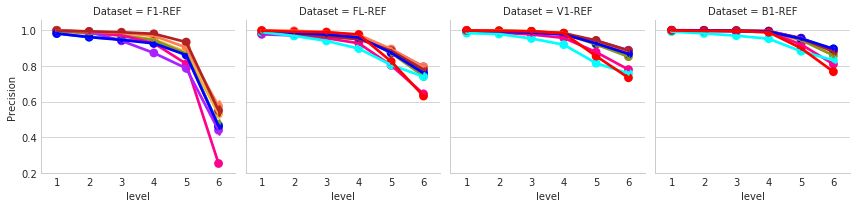

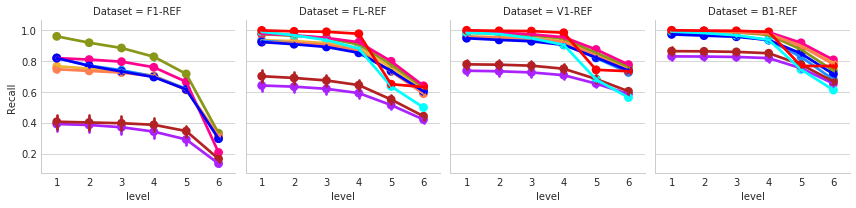

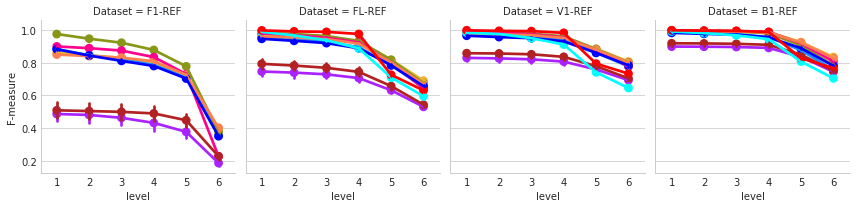

In [5]:
point = pointplot_from_data_frame(level_results, "level", y_vars,
                                  group_by="Dataset", color_by="Method",
                                  color_palette=color_palette)

In [6]:
for k, v in point.items():
    v.savefig(join(outdir, 'cross-val-{0}-lineplots.pdf'.format(k)))

## Per-level classification accuracy statistic
Kruskal-Wallis FDR-corrected p-values comparing classification methods at each level of taxonomic assignment

In [9]:
result = per_level_kruskal_wallis(level_results, y_vars, group_by='Method', 
                                  dataset_col='Dataset', alpha=0.05, 
                                  pval_correction='fdr_bh')
result

,Dataset,Variable,1,2,3,4,5,6
0,F1-REF,Precision,2.961263e-41,2.626454e-43,1.192886e-86,3.594780e-113,3.729349e-96,2.558304e-56
1,F1-REF,Recall,8.418474e-164,3.176551e-130,1.727216e-117,3.466313e-111,2.495417e-117,1.330441e-103
2,F1-REF,F-measure,5.988280e-149,4.341463e-122,7.224951e-113,5.816749e-112,2.273480e-123,1.647805e-103
3,FL-REF,Precision,3.035395e-130,4.058899e-118,5.688461e-97,1.167539e-61,1.024128e-28,8.689060e-37
4,FL-REF,Recall,8.420341e-133,3.281664e-116,3.986942e-118,1.237603e-113,7.890171e-114,1.682583e-118
5,FL-REF,F-measure,7.484644e-128,1.237603e-113,3.154655e-127,3.150288e-118,7.024918e-130,2.866068e-141
6,V1-REF,Precision,6.945713e-98,5.667266e-86,4.382183e-60,1.502881e-35,1.002144e-39,2.030641e-38
7,V1-REF,Recall,1.500942e-110,1.530141e-98,6.794485e-100,2.019428e-108,1.091653e-107,6.724234e-132
8,V1-REF,F-measure,9.607716e-102,1.329809e-93,4.612720e-105,9.158365e-125,1.530367e-136,4.219476e-155
9,B1-REF,Precision,1.010817e-27,3.605972e-59,6.234170e-47,4.604207e-32,1.455087e-23,6.063806e-27


## Heatmaps of method accuracy by parameter
Heatmaps show the performance of individual method/parameter combinations at each taxonomic level, in each reference database (i.e., for bacterial and fungal simulated datasets individually).

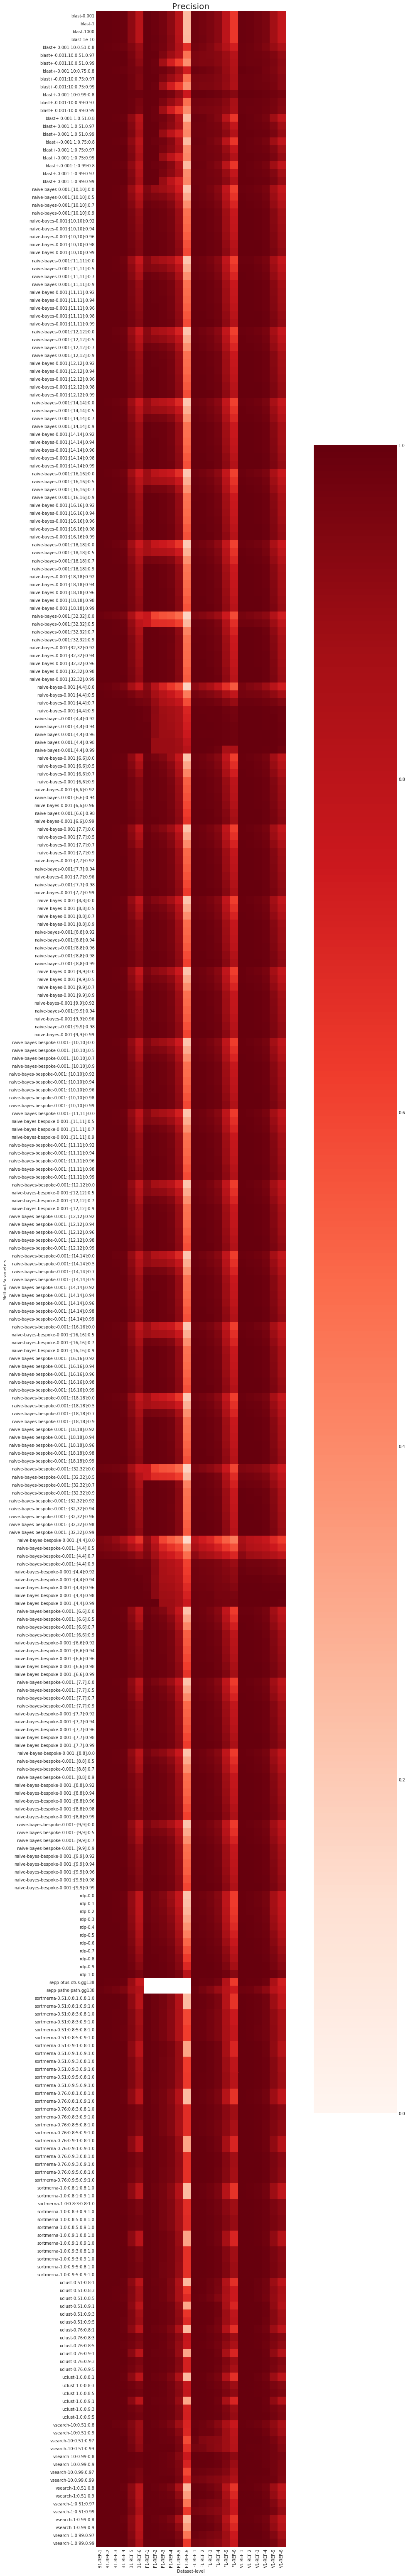

In [10]:
heatmap_from_data_frame(level_results, metric="Precision", rows=["Method", "Parameters"], cols=["Dataset", "level"])

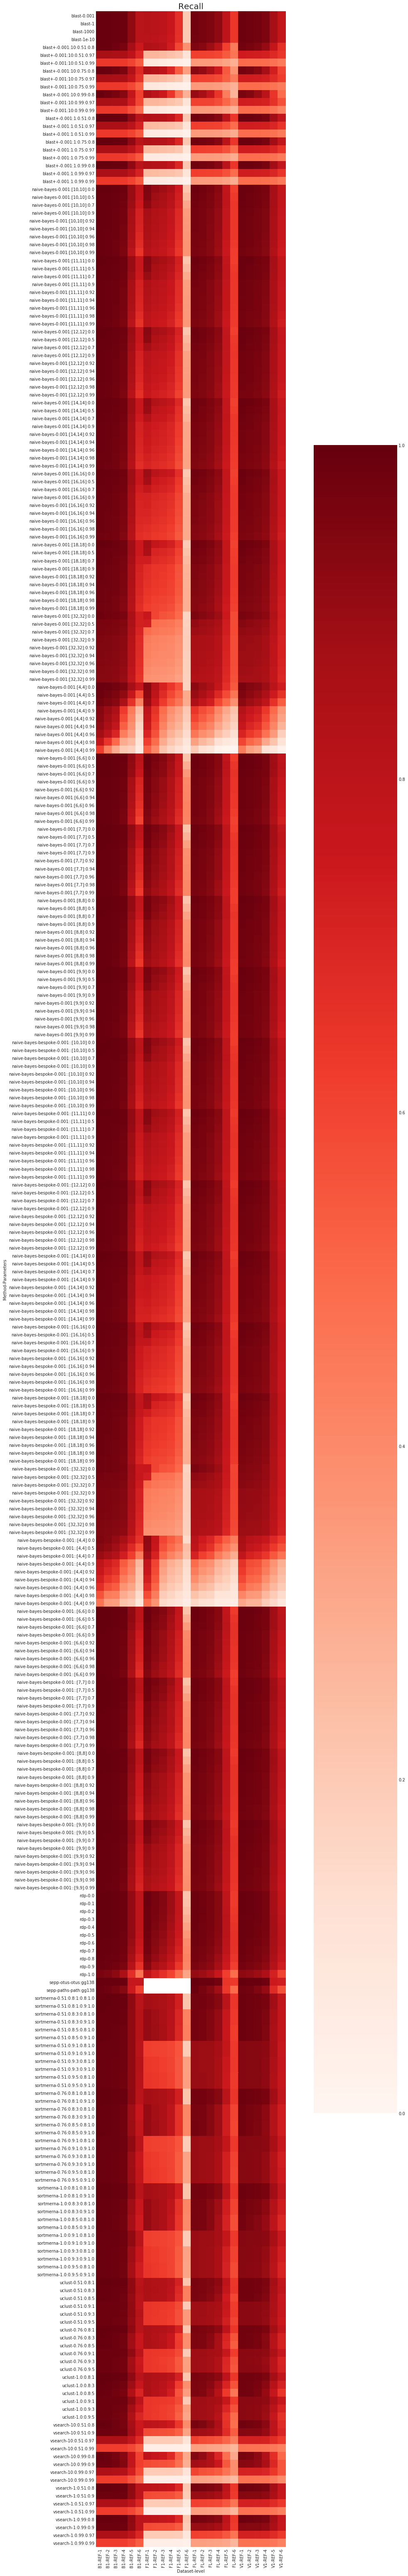

In [11]:
heatmap_from_data_frame(level_results, metric="Recall", rows=["Method", "Parameters"], cols=["Dataset", "level"])

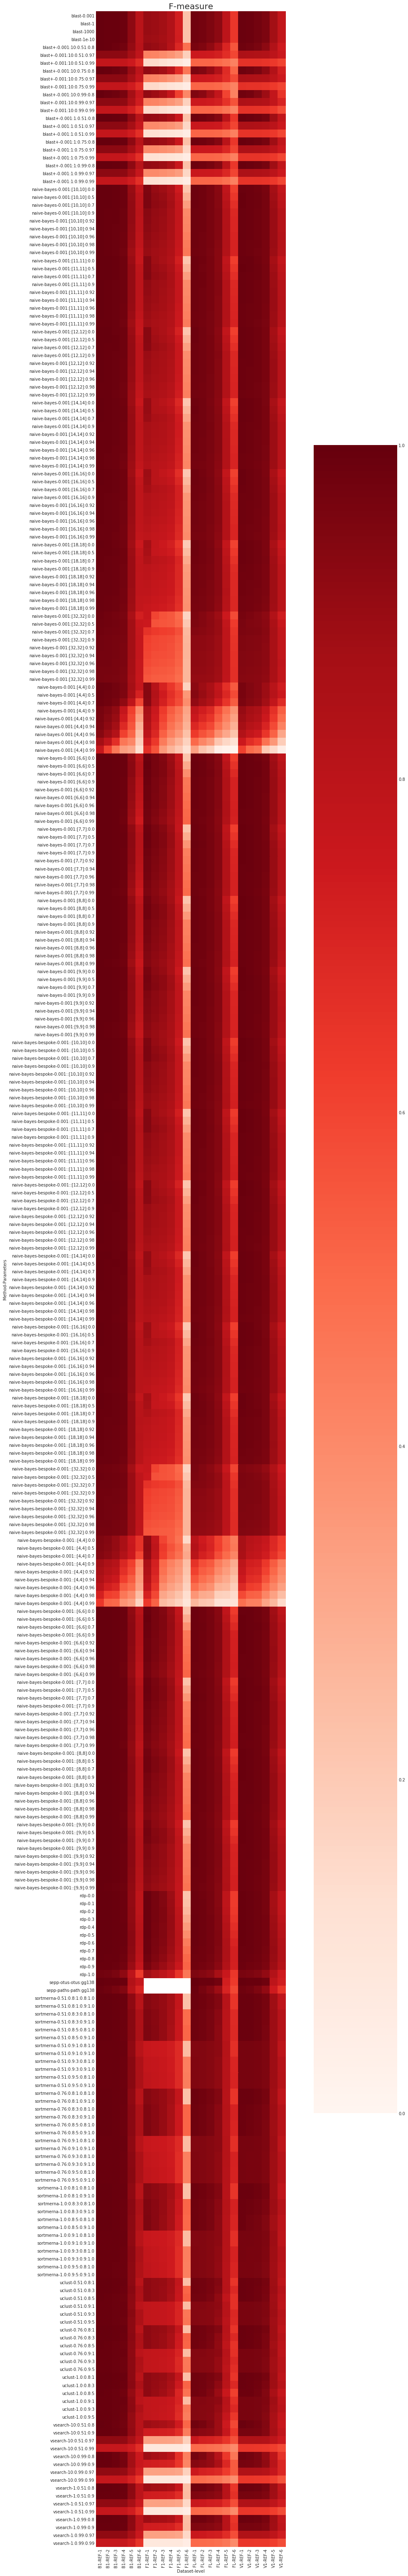

In [12]:
heatmap_from_data_frame(level_results, metric="F-measure", rows=["Method", "Parameters"], cols=["Dataset", "level"])

## Rank-based statistics comparing the performance of the optimal parameter setting run for each method on each data set.
Rank parameters for each method to determine the best parameter configuration within each method. *Count best* values in each column indicate how many samples a given method achieved within one mean absolute deviation of the best result (which is why they may sum to more than the total number of samples).

In [15]:
for method in level_results['Method'].unique():
    top_params = parameter_comparisons(level_results, method, metrics=y_vars, 
                                       sample_col='Dataset', method_col='Method',
                                       dataset_col='Dataset')
    display(Markdown('## {0}'.format(method)))
    display(top_params[:10])

## sortmerna

,F-measure,Precision,Recall
0.51:0.8:1:0.8:1.0,160,160,160
1.0:0.8:1:0.8:1.0,160,160,160
0.51:0.8:1:0.9:1.0,160,160,160
0.76:0.8:3:0.9:1.0,160,179,146
0.76:0.8:3:0.8:1.0,160,179,146
0.76:0.8:1:0.9:1.0,160,160,160
0.76:0.8:1:0.8:1.0,160,160,160
1.0:0.8:3:0.8:1.0,160,179,146
1.0:0.8:3:0.9:1.0,160,179,146
0.51:0.8:3:0.9:1.0,160,160,160


## naive-bayes

,F-measure,Precision,Recall
"0.001:[6,6]:0.7",171.0,170,170.0
"0.001:[6,6]:0.5",170.0,161,170.0
"0.001:[7,7]:0.7",169.0,169,170.0
"0.001:[7,7]:0.5",168.0,161,170.0
"0.001:[7,7]:0.9",168.0,178,161.0
"0.001:[6,6]:0.0",164.0,159,170.0
"0.001:[7,7]:0.92",164.0,180,160.0
"0.001:[8,8]:0.7",164.0,170,167.0
"0.001:[8,8]:0.5",164.0,161,170.0
"0.001:[6,6]:0.9",164.0,180,160.0


## rdp

,F-measure,Precision,Recall
0.5,161,170,162
0.6,161,173,160
0.0,160,160,162
0.1,160,160,162
0.2,160,160,163
0.3,160,160,163
0.4,160,164,163
0.7,160,186,157
0.8,160,196,150
0.9,159,200,131


## blast

,F-measure,Precision,Recall
1e-10,162,168,161
0.001,161,167,161
1,161,167,161
1000,161,167,161


## blast+

,F-measure,Precision,Recall
0.001:1:0.51:0.8,184.0,154,196.0
0.001:1:0.75:0.8,184.0,154,196.0
0.001:1:0.99:0.8,184.0,154,196.0
0.001:10:0.51:0.8,174.0,139,167.0
0.001:10:0.75:0.8,160.0,178,150.0
0.001:10:0.99:0.8,144.0,220,129.0
0.001:10:0.75:0.97,40.0,169,3.0
0.001:10:0.99:0.97,40.0,183,3.0
0.001:10:0.51:0.97,40.0,151,4.0
0.001:1:0.51:0.97,40.0,167,4.0


## uclust

,F-measure,Precision,Recall
0.51:0.8:3,161,160,161
0.51:0.8:1,160,160,161
1.0:0.8:1,160,160,161
0.51:0.8:5,160,157,160
0.76:0.8:1,160,160,161
0.76:0.8:3,160,191,154
0.76:0.8:5,160,179,153
1.0:0.8:3,160,191,154
1.0:0.8:5,153,210,133
0.51:0.9:3,120,170,93


## vsearch

,F-measure,Precision,Recall
1:0.51:0.9,188.0,170,178.0
1:0.99:0.9,188.0,170,178.0
1:0.51:0.8,187.0,161,198.0
1:0.99:0.8,187.0,161,198.0
10:0.51:0.9,178.0,169,159.0
10:0.51:0.8,176.0,159,179.0
10:0.99:0.9,170.0,210,139.0
10:0.99:0.8,163.0,214,144.0
1:0.51:0.97,40.0,168,0.0
1:0.99:0.97,40.0,168,0.0


## naive-bayes-bespoke

,F-measure,Precision,Recall
"0.001::[7,7]:0.94",172.0,183,163.0
"0.001::[9,9]:0.96",171.0,181,150.0
"0.001::[7,7]:0.92",171.0,178,164.0
"0.001::[7,7]:0.5",170.0,162,171.0
"0.001::[6,6]:0.9",170.0,178,163.0
"0.001::[7,7]:0.7",170.0,170,170.0
"0.001::[7,7]:0.96",170.0,185,160.0
"0.001::[6,6]:0.92",170.0,183,163.0
"0.001::[8,8]:0.92",170.0,175,162.0
"0.001::[8,8]:0.96",169.0,183,157.0


## sepp-paths

,F-measure,Precision,Recall
path:gg138,116,106,116


## sepp-otus

,F-measure,Precision,Recall
otus:gg138,116,116,116


## Rank performance of optimized methods
Now we rank the top-performing method/parameter combination for each method at genus and species levels. Methods are ranked by top F-measure, and the average value for each metric is shown (rather than count best as above). F-measure distributions are plotted for each method, and compared using paired t-tests with FDR-corrected P-values. This cell does not need to be altered, unless if you wish to change the *metric* used for sorting best methods and for plotting.

## F1-REF level 6

,Method,Parameters,Precision,Recall,F-measure
6,uclust,0.51:0.8:5,0.684296,0.429991,0.528025
4,rdp,0.9,0.697787,0.411087,0.517324
3,naive-bayes-bespoke,"0.001::[6,6]:0.99",0.653155,0.422298,0.512867
5,sortmerna,0.76:0.8:5:0.9:1.0,0.673183,0.412841,0.511767
2,naive-bayes,"0.001:[6,6]:0.99",0.655488,0.419046,0.511161
7,vsearch,10:0.51:0.8,0.705452,0.397744,0.508549
1,blast+,0.001:10:0.51:0.8,0.671470,0.378932,0.484280
0,blast,1e-10,0.255774,0.206764,0.228650


stat             P         FDR P
Method A    Method B                                                  
sortmerna   naive-bayes           0.115035  9.109433e-01  9.109433e-01
            rdp                  -1.072111  3.115754e-01  3.793092e-01
            blast                36.874644  3.931868e-11  2.285477e-10
            blast+                7.762333  2.814248e-05  7.879894e-05
            uclust               -3.147397  1.178682e-02  2.200207e-02
            vsearch               0.827187  4.295167e-01  4.810587e-01
            naive-bayes-bespoke  -0.209640  8.386170e-01  8.696769e-01
naive-bayes rdp                  -1.074151  3.107085e-01  3.793092e-01
            blast                43.485879  8.980502e-12  8.381802e-11
            blast+                4.673727  1.162454e-03  2.324909e-03
            uclust               -2.445055  3.705609e-02  6.484816e-02
            vsearch               0.605364  5.598905e-01  6.029590e-01
            naive-bayes-bespoke  -1.107819  2.966667e-01  3.793092e-01
rdp         blast                53.546691  1.389022e-12  3.889260e-11
            blast+                5.851767  2.432225e-04  6.191119e-04
            uclust               -1.908000  8.874521e-02  1.380481e-01
            vsearch               1.588344  1.466713e-01  2.161472e-01
            naive-bayes-bespoke   0.904331  3.893849e-01  4.542824e-01
blast       blast+              -30.947561  1.881978e-10  7.527912e-10
            uclust              -35.980379  4.897450e-11  2.285477e-10
            vsearch             -36.292970  4.532830e-11  2.285477e-10
            naive-bayes-bespoke -44.680526  7.043922e-12  8.381802e-11
blast+      uclust              -14.520262  1.495592e-07  5.234573e-07
            vsearch              -9.421093  5.864727e-06  1.824582e-05
            naive-bayes-bespoke  -5.208140  5.579570e-04  1.301900e-03
uclust      vsearch               4.998257  7.407280e-04  1.595414e-03
            naive-bayes-bespoke   2.361189  4.251842e-02  7.003034e-02
vsearch     naive-bayes-bespoke  -1.127807  2.885688e-01  3.793092e-01

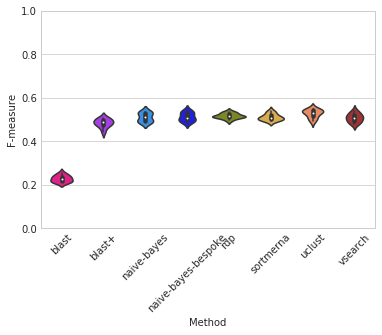

## FL-REF level 6

,Method,Parameters,Precision,Recall,F-measure
3,naive-bayes-bespoke,"0.001::[6,6]:0.98",0.858982,0.638894,0.732615
4,rdp,0.8,0.834501,0.641279,0.725081
2,naive-bayes,"0.001:[6,6]:0.98",0.861720,0.623944,0.723668
7,sortmerna,1.0:0.9:3:0.8:1.0,0.881331,0.606603,0.718535
8,uclust,0.51:0.9:3,0.786805,0.628062,0.698448
9,vsearch,1:0.51:0.9,0.696668,0.627951,0.660503
1,blast+,0.001:1:0.51:0.8,0.646154,0.642708,0.644425
0,blast,1e-10,0.643504,0.638957,0.641222
5,sepp-otus,otus:gg138,0.630931,0.630931,0.630931
6,sepp-paths,path:gg138,0.739767,0.498251,0.595328


stat             P         FDR P
Method A            Method B                                                  
sortmerna           rdp                  -0.969565  3.575963e-01  3.742287e-01
                    blast+               24.872942  1.317237e-09  1.481892e-08
                    sepp-paths           25.059817  1.232498e-09  1.481892e-08
                    naive-bayes          -0.929700  3.767889e-01  3.853522e-01
                    uclust                5.259159  5.213157e-04  7.567486e-04
                    vsearch              12.279750  6.325975e-07  1.293949e-06
                    naive-bayes-bespoke  -2.366478  4.215156e-02  4.788559e-02
                    blast                18.992628  1.431574e-08  6.442085e-08
                    sepp-otus            16.890000  4.008726e-08  1.503272e-07
rdp                 blast+               16.476728  4.978235e-08  1.723235e-07
                    sepp-paths           17.932106  2.372120e-08  9.704129e-08
                    naive-bayes           0.522776  6.137543e-01  6.137543e-01
                    uclust                3.158406  1.157988e-02  1.406537e-02
                    vsearch              14.676603  1.363001e-07  4.381075e-07
                    naive-bayes-bespoke  -2.082253  6.701999e-02  7.180714e-02
                    blast                21.592052  4.615839e-09  2.688995e-08
                    sepp-otus            14.190090  1.825130e-07  4.562825e-07
blast+              sepp-paths            9.271251  6.692448e-06  1.204641e-05
                    naive-bayes         -19.862692  9.648226e-09  4.824113e-08
                    uclust              -10.076008  3.359553e-06  6.573039e-06
                    vsearch              -5.104065  6.416215e-04  9.022803e-04
                    naive-bayes-bespoke -21.506682  4.780435e-09  2.688995e-08
                    blast                 2.360522  4.256497e-02  4.788559e-02
                    sepp-otus             3.142641  1.187742e-02  1.406537e-02
sepp-paths          naive-bayes         -21.922083  4.036134e-09  2.688995e-08
                    uclust              -14.433125  1.575646e-07  4.439121e-07
                    vsearch             -10.017749  3.525803e-06  6.610880e-06
                    naive-bayes-bespoke -23.525278  2.159709e-09  1.943738e-08
                    blast                -7.976235  2.266705e-05  3.777842e-05
                    sepp-otus            -4.360903  1.821068e-03  2.410237e-03
naive-bayes         uclust                3.358801  8.405160e-03  1.050645e-02
                    vsearch              13.808028  2.310537e-07  5.198708e-07
                    naive-bayes-bespoke  -4.863915  8.909889e-04  1.214985e-03
                    blast                26.629564  7.181014e-10  1.481892e-08
                    sepp-otus            13.984715  2.070278e-07  4.903290e-07
uclust              vsearch               6.234542  1.524244e-04  2.365206e-04
                    naive-bayes-bespoke  -4.056178  2.858292e-03  3.674947e-03
                    blast                 9.210553  7.063662e-06  1.222557e-05
                    sepp-otus            13.326879  3.136611e-07  6.721308e-07
vsearch             naive-bayes-bespoke -14.397520  1.609712e-07  4.439121e-07
                    blast                 6.452811  1.177540e-04  1.892475e-04
                    sepp-otus             5.531630  3.649653e-04  5.474480e-04
naive-bayes-bespoke blast                28.030019  4.550118e-10  1.481892e-08
                    sepp-otus            14.329580  1.677001e-07  4.439121e-07
blast               sepp-otus             2.136608  6.135877e-02  6.734499e-02

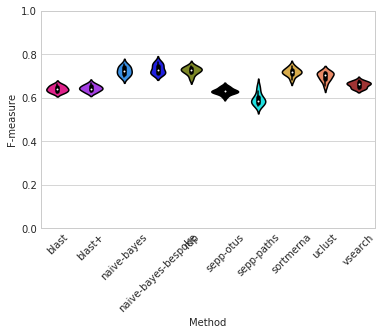

## V1-REF level 6

,Method,Parameters,Precision,Recall,F-measure
3,naive-bayes-bespoke,"0.001::[7,7]:0.94",0.896715,0.784840,0.837026
4,rdp,0.7,0.891607,0.784461,0.834580
2,naive-bayes,"0.001:[7,7]:0.92",0.891745,0.772479,0.827798
7,sortmerna,0.51:0.9:5:0.8:1.0,0.882904,0.766207,0.820378
8,uclust,0.51:0.8:3,0.855632,0.786654,0.819671
9,vsearch,1:0.51:0.9,0.818299,0.769046,0.792887
1,blast+,0.001:1:0.51:0.8,0.785171,0.782489,0.783827
0,blast,1e-10,0.779492,0.776551,0.778018
5,sepp-otus,otus:gg138,0.733460,0.733460,0.733460
6,sepp-paths,path:gg138,0.757681,0.562582,0.645665


stat             P         FDR P
Method A            Method B                                                  
sepp-paths          sepp-otus           -23.506032  1.141054e-08  2.070631e-07
                    naive-bayes           0.000000  1.000000e+00  1.000000e+00
                    uclust                0.000000  1.000000e+00  1.000000e+00
                    blast                 0.000000  1.000000e+00  1.000000e+00
                    rdp                   0.000000  1.000000e+00  1.000000e+00
                    vsearch               0.000000  1.000000e+00  1.000000e+00
                    blast+                0.000000  1.000000e+00  1.000000e+00
                    naive-bayes-bespoke   0.000000  1.000000e+00  1.000000e+00
                    sortmerna             0.000000  1.000000e+00  1.000000e+00
sepp-otus           naive-bayes           0.000000  1.000000e+00  1.000000e+00
                    uclust                0.000000  1.000000e+00  1.000000e+00
                    blast                 0.000000  1.000000e+00  1.000000e+00
                    rdp                   0.000000  1.000000e+00  1.000000e+00
                    vsearch               0.000000  1.000000e+00  1.000000e+00
                    blast+                0.000000  1.000000e+00  1.000000e+00
                    naive-bayes-bespoke   0.000000  1.000000e+00  1.000000e+00
                    sortmerna             0.000000  1.000000e+00  1.000000e+00
naive-bayes         uclust                2.321518  4.537293e-02  7.853008e-02
                    blast                15.104932  1.061812e-07  6.825937e-07
                    rdp                  -3.315492  9.004749e-03  1.620855e-02
                    vsearch              12.478851  5.513596e-07  2.255562e-06
                    blast+               12.570825  5.177845e-07  2.255562e-06
                    naive-bayes-bespoke  -9.970893  3.666099e-06  9.704380e-06
                    sortmerna             2.227405  5.292053e-02  8.820089e-02
uclust              blast                18.148828  2.134668e-08  2.401502e-07
                    rdp                  -3.402224  7.845634e-03  1.471056e-02
                    vsearch              10.378731  2.623767e-06  7.835533e-06
                    blast+               12.694959  4.760001e-07  2.255562e-06
                    naive-bayes-bespoke  -5.345940  4.648262e-04  1.045859e-03
                    sortmerna            -0.237182  8.178265e-01  1.000000e+00
blast               rdp                 -14.301687  1.705523e-07  9.593565e-07
                    vsearch              -8.426003  1.458986e-05  3.647464e-05
                    blast+               -3.472406  7.022086e-03  1.436336e-02
                    naive-bayes-bespoke -20.409540  7.592562e-09  2.070631e-07
                    sortmerna           -19.071308  1.380421e-08  2.070631e-07
rdp                 vsearch              10.828661  1.837580e-06  5.906507e-06
                    blast+               11.733791  9.319161e-07  3.494685e-06
                    naive-bayes-bespoke  -1.140989  2.833248e-01  4.553434e-01
                    sortmerna             3.922625  3.496995e-03  7.493560e-03
vsearch             blast+                3.435728  7.440569e-03  1.455764e-02
                    naive-bayes-bespoke -17.251989  3.329504e-08  2.996554e-07
                    sortmerna           -10.304566  2.785967e-06  7.835533e-06
blast+              naive-bayes-bespoke -16.458892  5.025568e-08  3.769176e-07
                    sortmerna           -10.831188  1.833974e-06  5.906507e-06
naive-bayes-bespoke sortmerna             6.153501  1.680095e-04  3.979172e-04

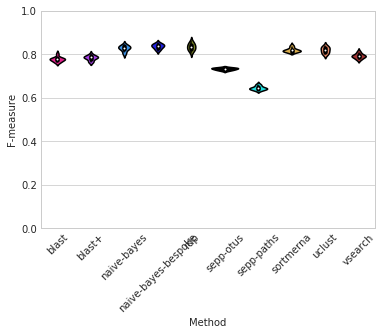

## B1-REF level 6

,Method,Parameters,Precision,Recall,F-measure
7,sortmerna,0.76:0.8:5:0.9:1.0,0.934980,0.781390,0.851284
8,uclust,0.51:0.8:3,0.873325,0.822354,0.847064
3,naive-bayes-bespoke,"0.001::[6,6]:0.7",0.884186,0.786815,0.832653
2,naive-bayes,"0.001:[6,6]:0.7",0.900455,0.765003,0.827215
9,vsearch,10:0.51:0.9,0.896329,0.755438,0.819837
4,rdp,0.5,0.847648,0.787429,0.816427
1,blast+,0.001:10:0.51:0.8,0.896382,0.749011,0.816035
0,blast,1e-10,0.809746,0.807025,0.808383
5,sepp-otus,otus:gg138,0.767236,0.767236,0.767236
6,sepp-paths,path:gg138,0.831612,0.611344,0.704596


stat             P         FDR P
Method A            Method B                                                  
blast+              sortmerna           -15.306849  9.460483e-08  1.637391e-07
                    uclust               -9.680066  4.687291e-06  6.906187e-06
                    naive-bayes-bespoke  -6.737585  8.483442e-05  1.090728e-04
                    blast                 2.164396  5.864626e-02  6.137399e-02
                    rdp                  -0.119500  9.075042e-01  9.075042e-01
                    naive-bayes          -3.413447  7.707449e-03  8.893210e-03
                    sepp-otus            15.997396  6.441764e-08  1.207831e-07
                    sepp-paths           32.499485  1.215925e-10  4.559720e-10
                    vsearch              -3.265361  9.754774e-03  1.097412e-02
sortmerna           uclust                2.183154  5.688143e-02  6.094439e-02
                    naive-bayes-bespoke   9.864858  4.006863e-06  6.217545e-06
                    blast                20.031778  8.953263e-09  2.120510e-08
                    rdp                  16.514100  4.880652e-08  9.549101e-08
                    naive-bayes          10.652090  2.109952e-06  3.516587e-06
                    sepp-otus            36.151223  4.694294e-11  2.072622e-10
                    sepp-paths           54.043226  1.278595e-12  3.778046e-11
                    vsearch              16.796992  4.207132e-08  8.605497e-08
uclust              naive-bayes-bespoke   9.868633  3.994149e-06  6.217545e-06
                    blast                30.420608  2.193630e-10  7.050954e-10
                    rdp                  21.114242  5.625700e-09  1.489156e-08
                    naive-bayes          17.015659  3.756941e-08  8.050587e-08
                    sepp-otus            42.459183  1.112444e-11  8.904332e-11
                    sepp-paths           44.488668  7.320916e-12  8.236030e-11
                    vsearch               9.453657  5.700168e-06  8.015862e-06
naive-bayes-bespoke blast                15.624536  7.911704e-08  1.424107e-07
                    rdp                   9.662679  4.757596e-06  6.906187e-06
                    naive-bayes           3.423904  7.580973e-03  8.893210e-03
                    sepp-otus            52.258521  1.728268e-12  3.778046e-11
                    sepp-paths           50.110238  2.518698e-12  3.778046e-11
                    vsearch               5.952329  2.147231e-04  2.684039e-04
blast               rdp                  -8.961748  8.840670e-06  1.170089e-05
                    naive-bayes         -19.515871  1.126881e-08  2.535483e-08
                    sepp-otus            30.606157  2.077792e-10  7.050954e-10
                    sepp-paths           37.439055  3.432221e-11  1.930624e-10
                    vsearch              -3.781383  4.339772e-03  5.278102e-03
rdp                 naive-bayes          -9.033938  8.279083e-06  1.128966e-05
                    sepp-otus            27.965996  4.643745e-10  1.306053e-09
                    sepp-paths           36.715159  4.087324e-11  2.043662e-10
                    vsearch              -1.214379  2.555041e-01  2.613110e-01
naive-bayes         sepp-otus            40.186667  1.820786e-11  1.170505e-10
                    sepp-paths           42.151893  1.187244e-11  8.904332e-11
                    vsearch               2.421682  3.850425e-02  4.226076e-02
sepp-otus           sepp-paths           29.036093  3.323231e-10  9.969693e-10
                    vsearch             -20.106685  8.663286e-09  2.120510e-08
sepp-paths          vsearch             -35.844180  5.066410e-11  2.072622e-10

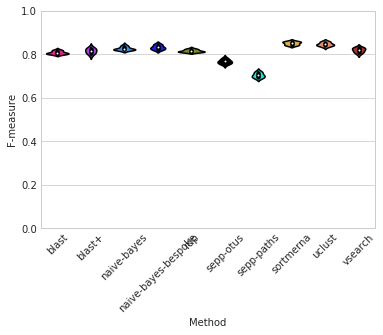

In [16]:
boxes = rank_optimized_method_performance_by_dataset(level_results,
                                                     metric="F-measure",
                                                     level="level",
                                                     level_range=range(6,7),
                                                     display_fields=["Method",
                                                                     "Parameters",
                                                                     "Precision",
                                                                     "Recall",
                                                                     "F-measure"],
                                                     paired=True,
                                                     parametric=True,
                                                     color=None,
                                                     color_palette=color_palette)

In [21]:
for k, v in boxes.items():
    v.get_figure().savefig(join(outdir, 'cross-val-{0}-boxplots.pdf'.format(k)))